In [1]:
import PyPDF2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
from transcript_functions import *

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rawin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rawin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
import pdftotext

df = pd.DataFrame(columns = ['raw_text','year'])

for k in range(10,20):
    
    pdfFileObj = open("C:/Users/rawin/Documents/GitHub/Capstone-Project/Proxies/Kroger/20%s_proxy.pdf"%(k),'rb')
    pdf = pdftotext.PDF(pdfFileObj)
    
    year = "20%s"%(k)
    company = "Kroger"

    sub_df = pd.DataFrame(columns = ['raw_text','year'])
    for page in pdf:
        x = page.replace('\n \n',', ')
        x = page.replace('\n',' ')
        sub_df = sub_df.append({'raw_text':x,'year':year,'company':company},ignore_index=True)

    df = pd.concat([df,sub_df],ignore_index=True)

In [3]:
df.shape

(1290, 3)

In [4]:
#remove numbers
df['raw_text'] =  df['raw_text'].map(lambda x: re.sub(r'\d+', '', x))

stop_words = set(stopwords.words('english'))

punctuations = ['(',')',';',':','[',']',',','.',"''",'$','%','``',"’",".//","”",'-','˜˜','@','?','...']

#tokenize, lower-case, remove stopwords, and remove punctuations
df["tokens_clean"] = df["raw_text"].map(lambda x: [word.lower() for word in word_tokenize(x) 
                                                   if word not in stop_words and word not in punctuations])

In [5]:
# tag Part of Speech
df["tokens_pos"] = df["tokens_clean"].map(nltk.pos_tag)
# filter words with pos not in pos_keep
pos_keep = ["NN", "NNS","VB", "VBD", "VBN", "VBP", "VBZ"] #take out "JJ", "JJR", "JJS"
df["tokens_pos"] = df["tokens_pos"].map(lambda x: [tup for tup in x if tup[1] in pos_keep])

# lemmatize with POS
lemmatizer = WordNetLemmatizer()
df["tokens_final"] = df["tokens_pos"].map(lambda x: [lemmatizer.lemmatize(tup[0], get_wordnet_pos(tup[1])) for tup in x ])

df["tokens_final"] = df["tokens_final"].map(lambda x: [word for word in x if len(word)>3])


In [6]:
remove_words =['shareholders','board','mr.','director','committee','proxy','meeting','share',
               'vote','shareholder','stock','plan','kroger']

df["tokens_final"] = df["tokens_final"].map(lambda x: [word for word in x if word.lower() not in remove_words])

In [7]:
#keeping only rows that has more than 3 elements in tokens_final
df = df[df['tokens_final'].apply(lambda x: len(x) > 5)]

In [8]:
kroger_df = df[['year','company','tokens_final']]

kroger_df.to_csv(path_or_buf ='C:\\Users\\rawin\\Documents\\GitHub\\Capstone-Project\\Proxies\\All\\kroger.csv', index = False)

In [9]:
import gensim
from gensim.utils import simple_preprocess
from gensim.test.utils import common_corpus, common_dictionary

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [10]:
dictionary = gensim.corpora.Dictionary(df["tokens_final"])

dictionary.filter_extremes(no_below=1, no_above=0.5) #, keep_n=100000)

bow_corpus = [dictionary.doc2bow(word) for word in df["tokens_final"]]

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, 
                                       passes=2, workers=2, chunksize=100, random_state=1000)

In [11]:
pp.pprint(lda_model.print_topics())

[   (   0,
        '0.035*"cost" + 0.025*"credit" + 0.022*"liability" + '
        '0.015*"obligation" + 0.014*"facility" + 0.013*"asset" + 0.013*"claim" '
        '+ 0.013*"estimate" + 0.013*"rate" + 0.012*"inventory"'),
    (   1,
        '0.034*"person" + 0.028*"section" + 0.028*"mean" + 0.025*"time" + '
        '0.022*"award" + 0.020*"participant" + 0.015*"exchange" + 0.014*"code" '
        '+ 0.014*"respect" + 0.014*"make"'),
    (   2,
        '0.029*"service" + 0.027*"chairman" + 0.026*"management" + '
        '0.025*"policy" + 0.024*"structure" + 0.024*"governance" + '
        '0.022*"serve" + 0.021*"leadership" + 0.018*"member" + 0.018*"role"'),
    (   3,
        '0.037*"cash" + 0.027*"statement" + 0.025*"activity" + 0.022*"income" '
        '+ 0.021*"earnings" + 0.019*"interest" + 0.016*"week" + '
        '0.016*"control" + 0.015*"provide" + 0.014*"capital"'),
    (   4,
        '0.037*"rate" + 0.035*"pension" + 0.034*"asset" + 0.020*"expense" + '
        '0.020*"benefit" + 0

In [12]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

In [13]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.017135  0.242968       1        1  13.885899
0      0.065815  0.187018       2        1  10.037475
11    -0.020247 -0.100581       3        1   9.552698
7     -0.265166 -0.036664       4        1   8.308109
6     -0.118777 -0.024402       5        1   8.285244
13     0.073685  0.165771       6        1   7.729636
14     0.179814 -0.140671       7        1   7.558171
8      0.223111  0.005588       8        1   6.010474
12    -0.137055  0.120974       9        1   5.650393
10     0.054548 -0.033085      10        1   5.409417
2      0.081810 -0.205185      11        1   5.071527
3      0.090754  0.079443      12        1   3.903308
5     -0.155352  0.021032      13        1   2.886814
9      0.088957 -0.144001      14        1   2.873831
1     -0.179031 -0.138203      15        1   2.837008, topic_info=             Term         Freq        Total Category  logprob  loglift
491  compensation  3106.000000  3106.000000  Default  30.0000  30.0000
280         award  1527.000000  1527.000000  Default  29.0000  29.0000
744       benefit  1836.000000  1836.000000  Default  28.0000  28.0000
267       pension  1388.000000  1388.000000  Default  27.0000  27.0000
940   participant  1207.000000  1207.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
507    subsidiary    43.786503   323.760773  Topic15  -4.7923   1.5617
955     agreement    55.369652   859.306213  Topic15  -4.5576   0.8203
30        provide    53.194740  1056.518066  Topic15  -4.5977   0.5736
37       security    47.132511   548.660278  Topic15  -4.7187   1.1079
491  compensation    54.113205  3106.701416  Topic15  -4.5805  -0.4878

[1056 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
1389      6  0.941458             absent
388       3  0.030588         abstention
388       7  0.030588         abstention
388      10  0.214115         abstention
388      12  0.030588         abstention
...     ...       ...                ...
714       7  0.149473            writing
714      15  0.597891            writing
2568     12  0.936236  www.proxyvote.com
2259     10  0.928377        www.sec.gov
1580      1  0.894058        zero-coupon

[4357 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 12, 8, 7, 14, 15, 9, 13, 11, 3, 4, 6, 10, 2])

In [14]:
df.columns

Index(['raw_text', 'year', 'company', 'tokens_clean', 'tokens_pos',
       'tokens_final'],
      dtype='object')

## Finding the dominant topic in each page

In [15]:
def format_topics_pages(ldamodel=lda_model, corpus=bow_corpus, texts=df[['year','tokens_final']]):
    # Init output
    page_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                page_topics_df = page_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    page_topics_df.columns = ['topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    page_topics_df = pd.concat([texts,page_topics_df], axis=1)
    return(page_topics_df)


df_topic_pages_keywords = format_topics_pages(ldamodel=lda_model, corpus=bow_corpus, texts=df[['year','tokens_final']])

# Format
df_dominant_topic = df_topic_pages_keywords.reset_index()
df_dominant_topic = df_dominant_topic.drop('index',axis=1)

# Show
df_dominant_topic.head(10)

,year,tokens_final,topic,perc_contribution,topic_keywords
0,2010,"[section, statement, schedule, rule, informati...",10.0,0.9068,"proposal, material, hereof, statement, copy, n..."
1,NaN,NaN,13.0,0.4224,"earnings, sale, increase, dilute, fuel, result..."
2,NaN,NaN,8.0,0.5441,"packaging, audit, sale, plastic, pricewaterhou..."
3,2010,"[team, deliver, result, position, advantage, m...",8.0,0.9375,"packaging, audit, sale, plastic, pricewaterhou..."
4,2010,"[sale, grow, sale, objective, business, model,...",8.0,0.4759,"packaging, audit, sale, plastic, pricewaterhou..."
5,2010,"[commit, safety, safety, core, value, result, ...",5.0,0.7582,"security, benefit, control, price, change, mar..."
6,2010,"[challenge, look, pace, recovery, continue, in...",3.0,0.6431,"cash, statement, activity, income, earnings, i..."
7,2010,"[congratulation, winners, community, service, ...",10.0,0.6149,"proposal, material, hereof, statement, copy, n..."
8,2010,"[cincinnati, ohio, hold, energy, convention, c...",6.0,0.4612,"compensation, cash, executive, bonus, officer,..."
9,2010,"[cincinnati, ohio, solicit, cost, solicitation...",2.0,0.6619,"service, chairman, management, policy, structu..."


In [16]:
df_dominant_topic.shape

(1288, 5)

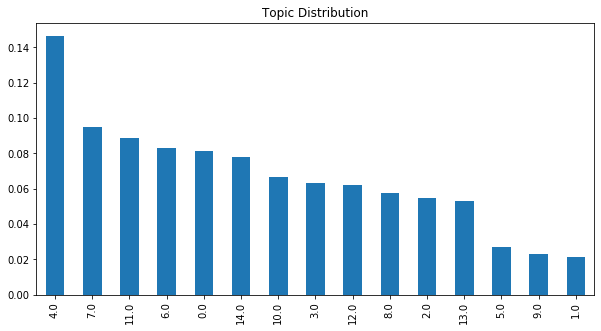

In [17]:
topic_counts = df_dominant_topic["topic"].value_counts()
(topic_counts/topic_counts.sum()).plot(x="Topics", y="Percentage",
                                       title="Topic Distribution",
                                       kind="bar", figsize=(10,5))

## Topic Trends

In [18]:
df_trend = pd.crosstab(df_dominant_topic["year"], df_dominant_topic["topic"], normalize="index")
years = [str(x) for x in df_trend.index]

In [19]:
df_trend

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
year,,,,,,,,,,,,,,,
2010,0.116438,0.027397,0.041096,0.095890,0.143836,0.034247,0.054795,0.054795,0.047945,0.020548,0.082192,0.075342,0.061644,0.075342,0.068493
2011,0.089172,0.031847,0.044586,0.070064,0.127389,0.038217,0.082803,0.121019,0.044586,0.019108,0.050955,0.076433,0.057325,0.057325,0.089172
2012,0.093750,0.015625,0.054688,0.078125,0.171875,0.015625,0.109375,0.062500,0.070312,0.007812,0.070312,0.093750,0.054688,0.031250,0.070312
2013,0.094203,0.007246,0.057971,0.065217,0.202899,0.014493,0.086957,0.079710,0.043478,0.014493,0.043478,0.079710,0.065217,0.057971,0.086957
2014,0.077419,0.025806,0.038710,0.064516,0.174194,0.038710,0.070968,0.148387,0.058065,0.012903,0.051613,0.070968,0.070968,0.045161,0.051613
2015,0.078014,0.007092,0.035461,0.063830,0.184397,0.042553,0.078014,0.049645,0.085106,0.028369,0.063830,0.085106,0.063830,0.056738,0.078014
2016,0.104167,0.006944,0.055556,0.069444,0.201389,0.020833,0.062500,0.055556,0.062500,0.013889,0.069444,0.069444,0.069444,0.069444,0.069444
2017,0.000000,0.015625,0.140625,0.015625,0.015625,0.015625,0.140625,0.093750,0.078125,0.078125,0.062500,0.171875,0.062500,0.000000,0.109375
2018,0.000000,0.040541,0.081081,0.013514,0.013514,0.013514,0.121622,0.229730,0.027027,0.067568,0.121622,0.135135,0.054054,0.000000,0.081081


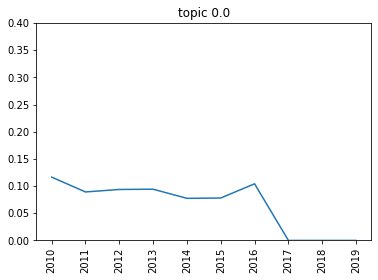

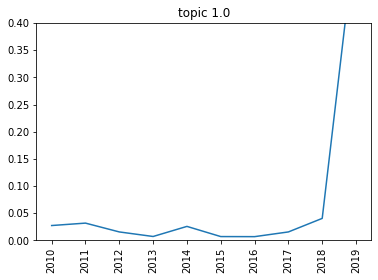

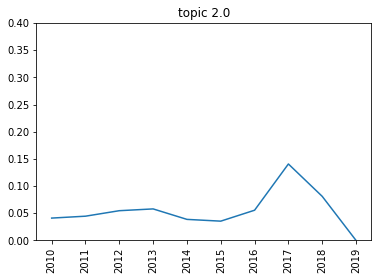

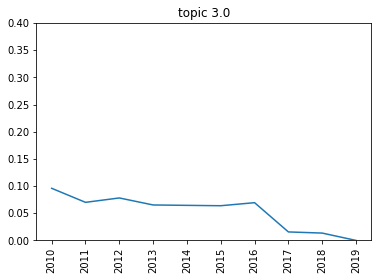

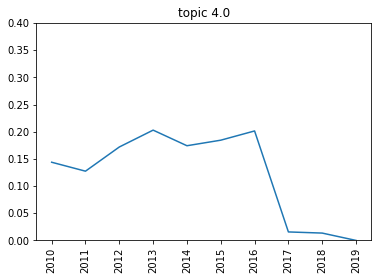

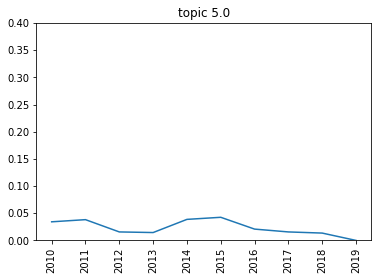

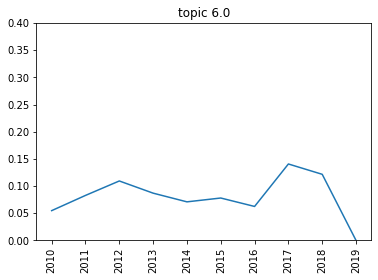

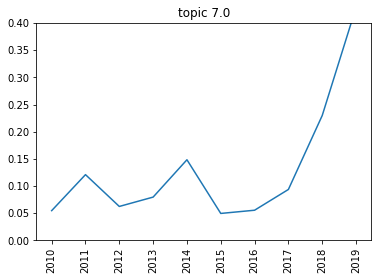

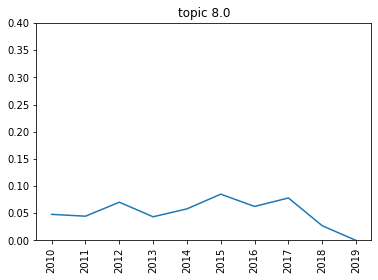

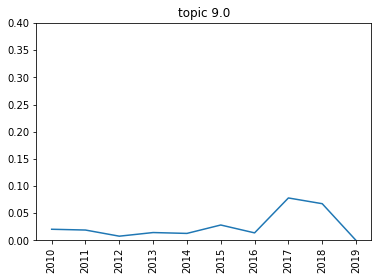

In [ ]:
for topic in df_trend:
    fig, ax = plt.subplots()
    plt.plot(years, df_trend[topic].values)
    plt.ylim(0, 0.4)
    plt.xticks(years, years, rotation='vertical')
    plt.title("topic "+ str(topic))